In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [160]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    # Drop all Unnamed columns
    cols = ["Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16","Unnamed: 17"]
    for col in cols:
        if col in df.columns:
            del df[col]
    # Drop "Person ID" column with too high cardinality
    df.drop(columns= "Person ID", inplace=True)
    
    # Drop "Gender" and "Sleep Disoder" columns with too low cardinality
    df.drop(columns=["Gender", "Sleep Disorder"], inplace=True)

    # Slip values in column "Blood Pressure" into "sys_value" and "dia_value" to determine Target Vector
    df[["sys_value", "dia_value"]] = df["Blood Pressure"].str.split("/", expand=True).astype(int)

    # Drop "Blood Pressure" & "sys_value" columns
    df.drop(columns=["Blood Pressure", "sys_value"], inplace=True)

    # let's make our Target Vector column a boolean value
    df["dia_value"] = (df["dia_value"]>80).astype(int)
    
    df.drop(columns= ["Occupation"], inplace=True)

    


    

   


    return df

In [155]:
filepath = "Blood-Pressure-determinants-in-individuals.csv"

In [161]:
df = wrangle(filepath)
df.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,dia_value
0,27,6.1,6,42,6,Overweight,77,4200,1
1,28,6.2,6,60,8,Normal,75,10000,0
2,28,6.2,6,60,8,Normal,75,10000,0
3,28,5.9,4,30,8,Obese,85,3000,1
4,28,5.9,4,30,8,Obese,85,3000,1


In [91]:
# Drop all Unnamed columns using for loop
cols = ["Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16","Unnamed: 17"]
for col in cols:
    if col in df.columns:
        del df[col]   

In [157]:
# Check columns with 'number' data type that has too high or too low cardinality
df.select_dtypes("number").nunique()

Age                        31
Sleep Duration             27
Quality of Sleep            6
Physical Activity Level    16
Stress Level                6
Heart Rate                 19
Daily Steps                20
dia_value                   2
dtype: int64

In [159]:
# Drop "Person ID" column with too high cardinality
df.drop(columns= ["Occupation"], inplace=True)

In [101]:
# Check columns with 'object' data type that has too high or too low cardinality
df.select_dtypes("object").nunique()

Occupation      11
BMI Category     4
dtype: int64

In [15]:
# Drop "Gender" and "Sleep Disoder" columns with too low cardinality
df.drop(columns=["Gender", "Sleep Disorder"], inplace=True)

In [92]:
# Slip values in column "Blood Pressure" into "sys_value" and "dia_value" to determine Target Vector
df[["sys_value", "dia_value"]] = df["Blood Pressure"].str.split("/", expand=True).astype(int)

In [95]:
# Drop "Blood Pressure" & "sys_value" columns
df.drop(columns=["Blood Pressure", "sys_value"], inplace=True)

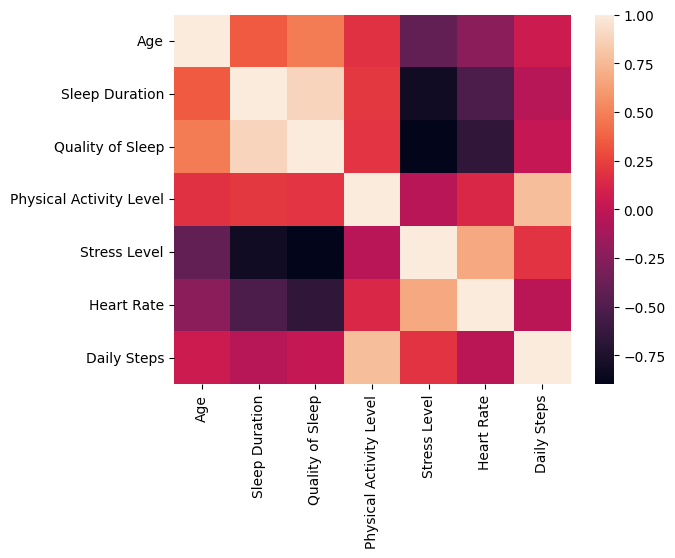

In [36]:
# Create correlation table to show relationship among 'number' data types without Target Vector 'dia_value'
# to show multicollinearity
corr = df.select_dtypes("number").drop(columns="dia_value").corr()
sns.heatmap(corr);

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      374 non-null    int64  
 1   Occupation               374 non-null    object 
 2   Sleep Duration           374 non-null    float64
 3   Quality of Sleep         374 non-null    int64  
 4   Physical Activity Level  374 non-null    int64  
 5   Stress Level             374 non-null    int64  
 6   BMI Category             374 non-null    object 
 7   Heart Rate               374 non-null    int64  
 8   Daily Steps              374 non-null    int64  
 9   dia_value                374 non-null    int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 29.3+ KB


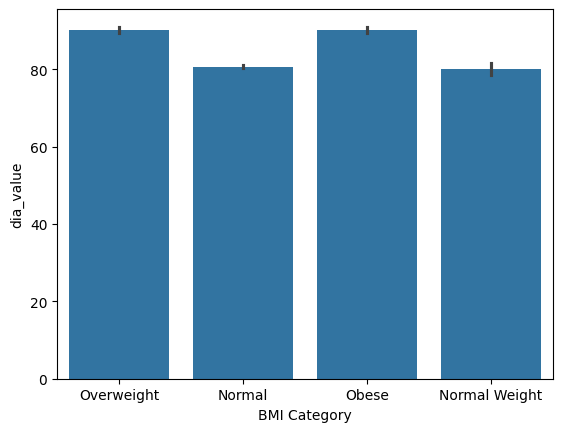

In [31]:
# Visualize relationship between "BMI Category" and "dia_value" with bar chart
sns.barplot(x="BMI Category", y="dia_value", data=df);

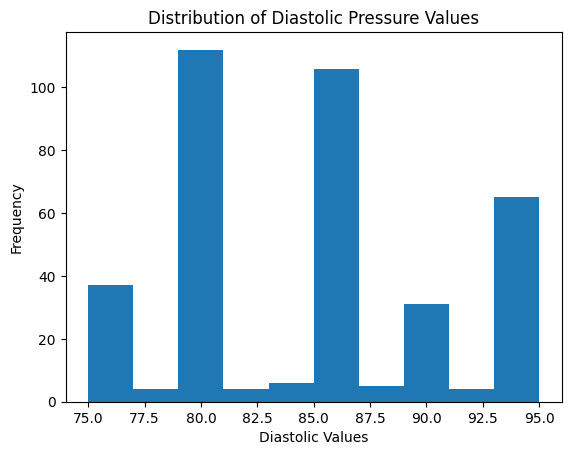

In [34]:
# Visualize distribution of Diastolic Pressure Value "dia_value" with histogram
plt.hist(df["dia_value"])
plt.xlabel("Diastolic Values")
plt.ylabel("Frequency")
plt.title("Distribution of Diastolic Pressure Values");

In [98]:
# let's make our Target Vector column a boolean value(above 80 is 1 & below 80 is 0)
(df["dia_value"]>80).astype(int).head()

0    1
1    0
2    0
3    1
4    1
Name: dia_value, dtype: int64

In [102]:
# Show the fraction of the "dia_value" with high and low values
df["dia_value"].value_counts(normalize=True)

dia_value
1    0.590909
0    0.409091
Name: proportion, dtype: float64

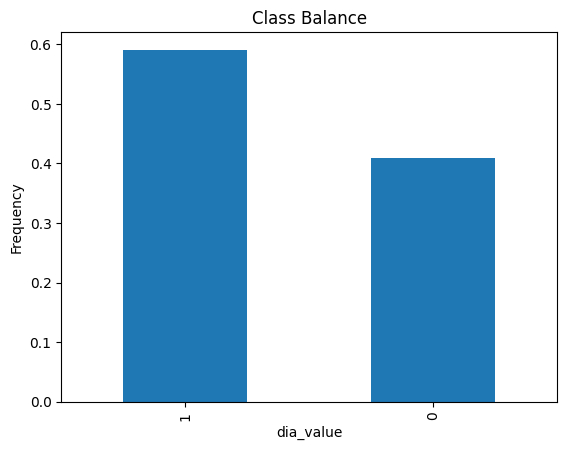

In [103]:
(df["dia_value"].value_counts(normalize=True)).plot(kind= "bar",
        xlabel="dia_value", ylabel="Frequency", title="Class Balance");

In [162]:
# Split the dataset into Feature Matrix "X" and Target Vector "y"
target = "dia_value"
X = df.drop(columns="dia_value", axis=1)
y = df[target]

print("X shape", X.shape)
print("y shape", y.shape)

X shape (374, 8)
y shape (374,)


In [163]:
# Split dataset (X and y) into training and test sets, set validation to 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

print("X_train: shape ", X_train.shape)
print("X_test: shape ", X_test.shape)
print("y_train: shape ", y_train.shape)
print("X_test: shape ", X_test.shape)

X_train: shape  (299, 8)
X_test: shape  (75, 8)
y_train: shape  (299,)
X_test: shape  (75, 8)


In [120]:
# LET'S START BUILDING OUR MODEL

In [164]:
# Assign Categorical and Numerical columns to 'cat_cols' & 'num_cols' respectively
cat_cols = ["BMI Category"]
num_cols = ["Age", "Sleep Duration", "Physical Activity Level", 
            "Quality of Sleep", "Stress Level", "Daily Steps", "Heart Rate"]

In [165]:
# Let's define our transformer
transformers = [("cat", OneHotEncoder(), cat_cols),
                ("num", StandardScaler(), num_cols)
]

In [166]:
# Create columntransformer and assign to 'preprocessor'
preprocessor = ColumnTransformer(transformers=transformers)

In [167]:
# Define 'model_dia' with the preprocessor and classifier
model_dia = Pipeline(steps=[("preprocessor", preprocessor),
                           ("classifier", DecisionTreeClassifier(random_state=42))]
    
)

In [168]:
# Use 'model_dia' to train X_train and y_train
model_dia.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['BMI Category']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Sleep Duration',
                                                   'Physical Activity Level',
                                                   'Quality of Sleep',
                                                   'Stress Level',
                                                   'Daily Steps',
                                                   'Heart Rate'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [169]:
# Determine the baseline accuracy 'acc_baseline' 
acc_baseline  = y_train.value_counts(normalize=True).max()
print("accuracy baseline:", round(acc_baseline, 2))

accuracy baseline: 0.59


In [136]:
# TIME TO EVALUATE OUR MODEL_DIA

In [170]:
# Calculate the training and test accuracy for model_dia
acc_train = model_dia.score(X_train, y_train)
acc_test = model_dia.score(X_test, y_test)

print(round(acc_train, 2))
print(round(acc_test, 2))

1.0
1.0


In [171]:
# Let's make prediction 'y_pred' from model_dia with'X_test' values
y_pred = model_dia.predict(X_test)
y_pred[:5]

array([0, 0, 0, 0, 0])

In [141]:
# LET'S GET FEATURES AND IMPORTANCES FROM OUR MODEL_DIA

In [172]:
# Let's access the preprocessor and the classifier
preprocessor = model_dia.named_steps["preprocessor"]
classifier = model_dia.named_steps["classifier"]

In [173]:
# Let's get Feature names from the preprocessor
onehot_cols = preprocessor.transformers_[0][1].get_feature_names_out(cat_cols)
scaled_cols = num_cols

In [174]:
# Now let's combine feature names in a variable 'feature_name'
feature_name = list(onehot_cols) + list(scaled_cols)

In [175]:
# Get feature importances from the classifier
importances = classifier.feature_importances_

In [176]:
# Create a data frame named 'feat_imp'
feat_imp = pd.DataFrame({
    "feature": feature_name,
    "importances": importances
}).sort_values(by="importances", ascending=False).set_index("feature")
print(feat_imp)

                            importances
feature                                
BMI Category_Overweight        0.443396
Heart Rate                     0.247151
Physical Activity Level        0.212142
Daily Steps                    0.082361
Quality of Sleep               0.013334
BMI Category_Normal Weight     0.001220
Age                            0.000397
BMI Category_Obese             0.000000
BMI Category_Normal            0.000000
Sleep Duration                 0.000000
Stress Level                   0.000000


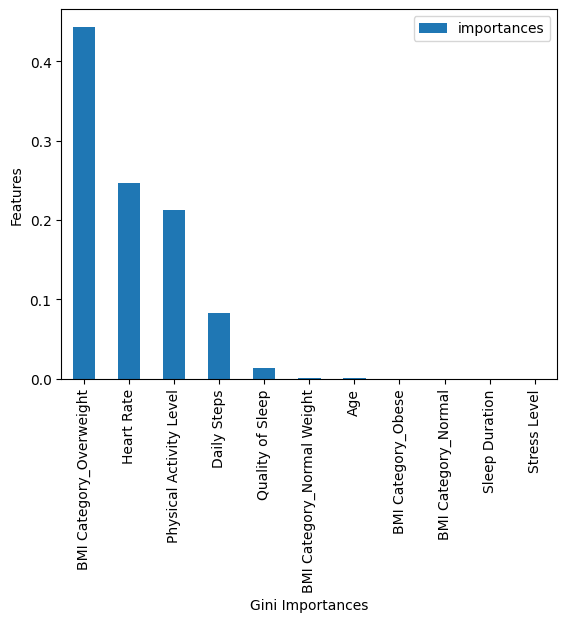

In [177]:
# Let's communicate predictions from model_dia with bar chart
feat_imp.plot(kind= "bar", xlabel="Gini Importances", ylabel="Features");